### Antonio Gagliardo | Recipe Sentiment Analysis and Recommendation System
# Index

## [Preparation](#Preparation)
## [Section 1: Exploring and Cleaning](#Section1)
## [Section 2: Balance the Data](#Section2)
## [Section 3: Tokenize, Vectorize, Logistic Regression](#Section3)
## [Section 4: TF-IDF Vectorizer with Logistic Regression](#Section4)
## [Section 5: Other models: KNN & Decision Tree](#Section5)


------------------
-----------------

# Intro

In this jupyter notebook, we will dive into sentiment analysis on reviews from Food.com, a popular recipe website. Join me as we explore the world of culinary delights and train/test models to predict the sentiment of these reviews.

This is very useful for businesses as it provides quick insights into the sentiment expressed by customers (mostly online), aBy accurately predicting sentiment and identifying the most frequently used words along with their sentiment, businesses can gain a deeper understanding of their customers. This would help them find what customers value, what they hate and adjust their services accordingly. If done by a model it can be cost-effective, since doing it mannually would require a lot of time and money, while a machine can do it on minutes.

 The goal of this notebook is to get top positive and negative keywords, and use one of the model to help predict if a sentence / review has a positive or negative sentiment. In this notebook I will be exploring models for sentiment analysis to have a few options on what model could be explored further.
 
### Dataset:
 The data was taken from Kaggle and is a dataset from Food.com
 credit to the person who created the dataset: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
 
 or you can use my **drive link** to download the dataset: https://drive.google.com/drive/folders/17rwRC48Lk1K36z6mU6M3t6ePOsDz51fR


# Preparation
Import libraries, load the dataset

In [87]:
import pandas as pd
import numpy as np
import nltk



import seaborn as sns
import matplotlib.pyplot as plt
import nltk



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet


import warnings
warnings.filterwarnings("ignore")


In [153]:
import streamlit as st
import pickle

In [88]:
# recipes = pd.read_csv('foodcom_with_reviews/recipes.csv')
reviews = pd.read_csv('foodcom_with_reviews/reviews.csv')

In [89]:
# recipes.head(1)

In [90]:
type(reviews)

pandas.core.frame.DataFrame

In [91]:
reviews.head(1)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z


# Section1
## Exploring and cleaning

First I will be checking the null values

In [92]:
reviews.isna().sum()

ReviewId           0
RecipeId           0
AuthorId           0
AuthorName         0
Rating             0
Review           214
DateSubmitted      0
DateModified       0
dtype: int64

In [93]:
reviews.loc[reviews['Review'].isna()]

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
165686,177521,121490,125458,eatrealfood,5,NaN,2017-03-24T13:32:48Z,2017-03-24T13:32:48Z
381499,408467,74971,362819,Loryn,4,NaN,2017-02-22T22:22:01Z,2017-02-22T22:22:01Z
511712,555485,22210,362819,Loryn,5,NaN,2017-02-22T22:03:55Z,2017-02-22T22:03:55Z
589730,643706,22274,448426,Kids Stuff,3,NaN,2017-06-09T03:10:30Z,2017-06-09T03:10:30Z
1109687,1270189,359662,547648,leanna.heiman,5,NaN,2017-05-30T05:25:20Z,2017-05-30T05:25:20Z
...,...,...,...,...,...,...,...,...
1378730,2065335,252449,2002310785,Cecily S.,4,NaN,2018-10-24T18:23:15Z,2018-10-24T18:23:15Z
1378916,2065538,122475,2002313998,ayateisheh,5,NaN,2018-10-27T21:58:55Z,2018-10-27T21:58:55Z
1380429,2067166,452478,2002360118,Nancy D.,5,NaN,2018-12-08T19:33:59Z,2018-12-08T19:33:59Z
1385870,2072984,12975,2002375480,Anonymous,5,NaN,2019-06-03T15:26:09Z,2019-06-03T15:26:09Z


gladly there are very few null values, I will remove them since they are a small fraction of my dataset (not even 0.1%)

In [94]:
type(reviews)

pandas.core.frame.DataFrame

In [95]:
reviews = reviews.dropna()


In [96]:
reviews.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           0
DateSubmitted    0
DateModified     0
dtype: int64

In [97]:
reviews.duplicated().sum()

0

Now with no duplicates or null values I will procede to to check more details in the data, for example if it is balanced.

# Section2
## Balance the Data

To train a model, the data has to be balanced, so in the code below I will explore if this is the case for this database.

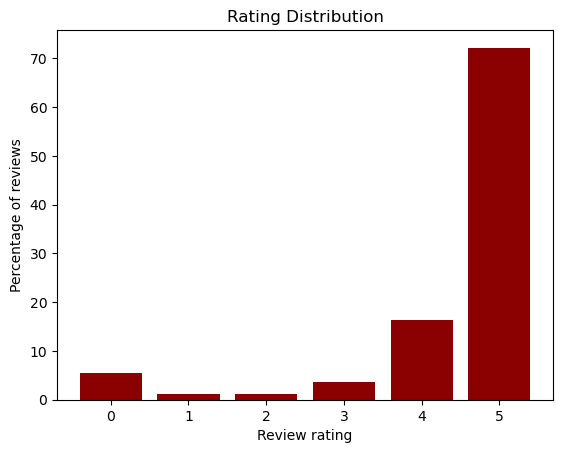

In [98]:
values, counts = np.unique(reviews['Rating'], return_counts = True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100, color = 'darkred')
plt.xlabel('Review rating')
plt.ylabel('Percentage of reviews')
plt.title('Rating Distribution')
plt.show()

In [99]:
reviews.shape

(1401768, 8)

By checking the graph above, it can be easily spotted that there is a huge imbalance on the Data. Most reviews are positive, also having different values could confuse my model, so I will make it binary to make my model have a more smooth training. 

What I will do is just give 2 options, '1' for good reviews and '0' for bad review.

In [100]:
# dropping reviews that are 3 or 4
reviews = reviews.drop(reviews[(reviews['Rating'] == 3) | (reviews['Rating'] == 4)].index)

I droped reviews that are 3 and 4 because I want to take only extremes to have a better training on if the word is positive or negative. 3 and 4 could be neutral or mixed review which could confuse my model.

In [101]:
reviews['Sentiment'] = np.where(reviews['Rating'] >=4, 1, 0) 
#later replace with reviews_simple or something like that
reviews.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z,1
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could taste the cornstarch in the finished product.,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z,0
3,13,7435,1773,Malarkey Test,5,"easily the best i have ever had. juicy flavorful, not dry. the vegetables retain crispness as well, not bland at all!",2000-03-13T21:15:00Z,2000-03-13T21:15:00Z,1


On the table above, on the last column that I created `Sentiment`, it is visible the 1 and 0 which are positive and negative reviews respectively. This will make it easier for taining my model since I am giving it a clear definition of what is positive and what is negative (a mixed review can be confusing for the training); in this way we reduce ambiguety.

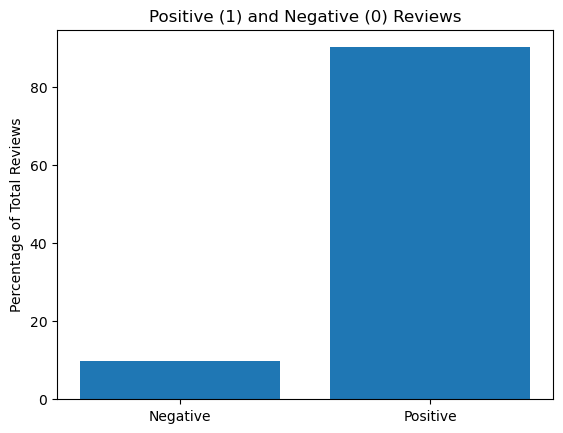

In [102]:
values, counts = np.unique(reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.title('Positive (1) and Negative (0) Reviews')
plt.ylabel('Percentage of Total Reviews')
plt.xticks(ticks = [0,1], labels=['Negative', 'Positive'])
plt.show()

In the graph bove we can observe the balance of our new column with the binary sentiment.

In [103]:
print(values)
print(counts)

[0 1]
[ 110399 1011912]


Sadly, this data is highly unbalanced. More than 80% of the reviews are positive. If I train my model like this, the model will always give me positive since its logic will be 'if I always send positive I will have more than 80% of being correct'. To avoid this, I will rebalance my reviews using $resample$ 

In [104]:
from sklearn.utils import resample

majority_sentiment = reviews[reviews['Sentiment'] == 1]  # Majority sentiment (positive)
minority_sentiment = reviews[reviews['Sentiment'] == 0]  # Minority sentiment (negative)

# Upsample the minority sentiment
oversampled_minority = resample(minority_sentiment,
                                replace=True,  # Allow duplication
                                n_samples=len(majority_sentiment), 
                                random_state=42)  

# Combine the majority sentiment with the oversampled minority sentiment
balanced_reviews = pd.concat([majority_sentiment, oversampled_minority])

# Shuffle the balanced dataset
balanced_reviews = balanced_reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In the code above I upsampled the negative reviews to have a more balanced dataset.

In [105]:
balanced_reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,212628,75103,252556,jtmmmatthews,5,I love this simply yet delicious recipe.\r\n\r\nI added cinnamon and nutmeg to my cool whip for extra spicy flavor!\r\n\r\nYummy!,2005-10-16T14:44:20Z,2005-10-16T14:44:20Z,1
1,484567,254184,356476,Lolas Mama,5,"I'm on a low fat low sodium diet, so it's really hard to find tasty things to eat.Considering there's under 1 g of fat in this recipe, these muffins are really good!I accidiently bought steel cut oats, so they had a kind of nutty texture.I ommited the salt, and the cinnamon and sugar on top, and added 40g of fat free dried cranberries, and 30g of chocolate chips (8g fat for entire recipe, or an extra .66g per muffin).Just that little bit of extras were worth it.Next time I may add fresh fruit-really the sky's the limit with this recipe-it's a very good base for any kind of extras you want.Thank you Tattooed Lady, for a GREAT recipe!",2007-09-23T17:49:47Z,2007-09-23T17:49:47Z,1
2,1085417,2886,68941,Trickey,0,Thanks for this wonderful recipe. I have made it many times now. I usually double the recipe and add 2-3 cups of chopped walnuts. It always comes out moist and delicious.,2010-04-16T10:55:46Z,2010-04-16T10:55:46Z,0
3,1452481,476676,1803083664,Ryan B.,5,The first time I made his recipe the cookies turned out too solid and round. I made another batch and the results were much better. Instead of baking powder I used baking soda and I used light sprinkles instead of the big chunky ones. When they were done the shape and taste were perfect. I whipped up homemade cream cheese frosting and put it between two cookies kinda like a macaroon. They were delicious.,2014-08-29T18:27:03Z,2014-08-29T18:27:03Z,1
4,2037971,48383,2001793617,Mary L.,0,I did a bone in Turkey for Thanksgiving. I put quartered onions and halved garlic in the bottom along with sage and thyme. I only added about 1 cup of chicken broth. I had to remove the ribs to get it to fit. It turned out great. For Christmas I'm going to do a boneless breast. Crockpot is th way to go!,2017-12-06T00:17:17Z,2017-12-06T00:17:17Z,0


While reviewing my data I also saw that I hve an extra idnex that I do not need, so I will replace the index with 'ReviewId'

In [106]:
# getting rid of the default index and replacing it with review id
balanced_reviews.set_index('ReviewId', inplace=True)
balanced_reviews.head()

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
212628,75103,252556,jtmmmatthews,5,I love this simply yet delicious recipe.\r\n\r\nI added cinnamon and nutmeg to my cool whip for extra spicy flavor!\r\n\r\nYummy!,2005-10-16T14:44:20Z,2005-10-16T14:44:20Z,1
484567,254184,356476,Lolas Mama,5,"I'm on a low fat low sodium diet, so it's really hard to find tasty things to eat.Considering there's under 1 g of fat in this recipe, these muffins are really good!I accidiently bought steel cut oats, so they had a kind of nutty texture.I ommited the salt, and the cinnamon and sugar on top, and added 40g of fat free dried cranberries, and 30g of chocolate chips (8g fat for entire recipe, or an extra .66g per muffin).Just that little bit of extras were worth it.Next time I may add fresh fruit-really the sky's the limit with this recipe-it's a very good base for any kind of extras you want.Thank you Tattooed Lady, for a GREAT recipe!",2007-09-23T17:49:47Z,2007-09-23T17:49:47Z,1
1085417,2886,68941,Trickey,0,Thanks for this wonderful recipe. I have made it many times now. I usually double the recipe and add 2-3 cups of chopped walnuts. It always comes out moist and delicious.,2010-04-16T10:55:46Z,2010-04-16T10:55:46Z,0
1452481,476676,1803083664,Ryan B.,5,The first time I made his recipe the cookies turned out too solid and round. I made another batch and the results were much better. Instead of baking powder I used baking soda and I used light sprinkles instead of the big chunky ones. When they were done the shape and taste were perfect. I whipped up homemade cream cheese frosting and put it between two cookies kinda like a macaroon. They were delicious.,2014-08-29T18:27:03Z,2014-08-29T18:27:03Z,1
2037971,48383,2001793617,Mary L.,0,I did a bone in Turkey for Thanksgiving. I put quartered onions and halved garlic in the bottom along with sage and thyme. I only added about 1 cup of chicken broth. I had to remove the ribs to get it to fit. It turned out great. For Christmas I'm going to do a boneless breast. Crockpot is th way to go!,2017-12-06T00:17:17Z,2017-12-06T00:17:17Z,0


Now I will just check how my new data looks like

In [107]:
print(f'Normal reviews: {reviews.shape}')
print(f'balanced reviews: {balanced_reviews.shape}')

Normal reviews: (1122311, 9)
balanced reviews: (2023824, 8)


In [108]:
balanced_reviews['Sentiment'].value_counts()

1    1011912
0    1011912
Name: Sentiment, dtype: int64

The new balanced reviews is a lot better than the old one, now its 50/50 intermns of positive/negative reviews. This way the training will not be biased to always give me positive reviews.

Now, the dataset has a total of more than 2 million reviews, which would be a nightmare to run through my models. So to make my life easier and avoid taking 2 hours everytime I run a mode, I will do a sample of 50,000 reviews

In [109]:
sample_size = 50000


# Check if the dataset has more than 50,000 rows
if len(balanced_reviews) > sample_size:
    # Take a random sample of 50,000 rows from the balanced_reviews DataFrame
    sample_reviews = balanced_reviews.sample(n=sample_size, random_state=1) 
else:
    # this is in case i set the sample to a number higher than the dataset
    sample_reviews = balanced_reviews

In [110]:
sample_reviews['Sentiment'].value_counts()

1    25048
0    24952
Name: Sentiment, dtype: int64

Just checking the balance of my sample to verify it is not biased.

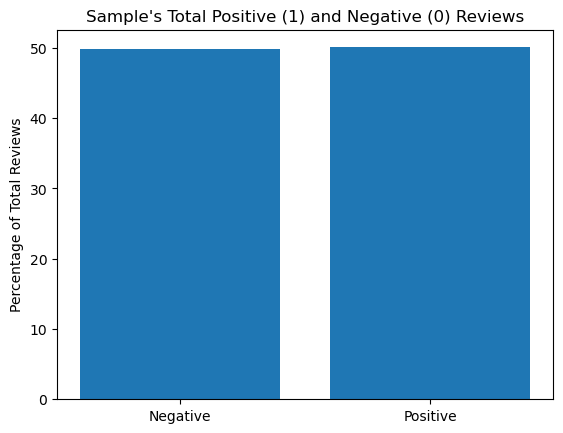

In [111]:
values, counts = np.unique(sample_reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.title("Sample's Total Positive (1) and Negative (0) Reviews")
plt.ylabel('Percentage of Total Reviews')
plt.xticks(ticks = [0,1], labels=['Negative', 'Positive'])
plt.show()

Why not making a graph to visualize the balance? this looks a lot better than the initial one, and will help make a better training for my model.

# Section 3
## Tokenize, Vectorize, Logistic Regression

In the following section I will break down the sentences into tokens, which will be necesary to vectorize the data. I will also break down my data into Training/validation and Testing.

First I did a function to tokenize the data. 

The tokenizer uses a stemmer to break down the words to a root form, then it will eliminate stop words (like articles, prepositions, pronouns, conjunctions) or any words that dont really add value to the analysis. Also it makes everything lower case to avoid having different versions of the word (lower and upper case)

In [112]:
def my_tokenizer(sentence):
    # Instantiate stemmer and stopwords from nltk
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Making them lower case and remove punctuation
    stemmed_words = [stemmer.stem(word.lower()) for word in words if word.isalpha()]

    # Remove if it is a stop words
    filtered_words = [word for word in stemmed_words if word not in stop_words]

    return filtered_words

In [113]:
# checking my tokenizer
example_sentence = "The quick brown fox, jumped over the lazy dog!!"
my_tokenizer(example_sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

I made an example abov eto check if the tokenizer is working, and it was a success!

-----
Now it is time to split the data. I used `Review` as my X and `Sentiment` as my Y. The data is split into train, validation and Test. 
70% of the data went to the training, and 30% of the data is separated to test the trained data. This means that I will test how accurate is my model on predicting that 30% of the data that it hasn't seen before.

In [114]:


X_sample = sample_reviews['Review'].astype(str)
y_sample = sample_reviews['Sentiment']

# Perform stratified sampling to obtain a balanced sample
X_remainder_sample, X_test_sample, y_remainder_sample, y_test_sample = train_test_split(X_sample, y_sample,  test_size=0.2, stratify=y_sample, random_state=1)

# Splitting the remainder in two chunks
X_train_sample, X_validation_sample, y_train_sample, y_validation_sample = \
    train_test_split(X_remainder_sample, y_remainder_sample, test_size = 0.3,
                     random_state=1)
    

In [115]:
X_train_sample.shape

(28000,)

In [116]:
X_test_sample.shape

(10000,)

In [117]:
# Combine the features and target back into a DataFrame
sampled_reviews = pd.concat([X_remainder_sample, y_remainder_sample], axis=1)
sampled_reviews.head(3)

,Review,Sentiment
ReviewId,,
1109027,"Delicious!!! ...and an easy to follow recipe. \n\nHowever, I found that the middle layer didn't set, even after an hour in the fridge... and later on when I cut it up, the downwards force of the knife cause most of the middle to leak out. Next time I make it I'll tweek the quantitys a little and see if I can make it set. \n\nAbsolutely beuatiful when you have a peanut butter craving though! Mmm.",1
1395449,"This actually turned out to be much more creamy than the usual baba ganouj that I actually make. I also found that the Greek yogurt turned out very well. I used the three largest garlic cloves I could find, and enjoyed the flavour it added.",1
472074,This recipe comes from a WW card several years back. I have used it many times with great results.,1


In [118]:
X_train_sample.head(3)

ReviewId
1382477                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 They forgot to to mention that when your oven is this hot and using this combination of ingredients ,  smoke will fill your house
2055925                                                                                                                                                                                              

In [119]:
X_test_sample.head(3)

ReviewId
1129184    This was really good. I added a some leftover chicken from another meal and it was a great dinner. Thanks DonnaR for a great comfort meal. Made for Cookbook Tag.
1465140                              it&#039;s simple and have a good taste.My family like it.I have add almond esensse and eat shortbread warm with ice-cream.Mmmmm...yammy
1224704    Very good rice dish. I used fresh pineapple, as I don't think canned has much flavour. My husband asked for a repeat. Made for New Kids on the Block Tag game. :)
Name: Review, dtype: object

Above I am just checking how my data looks like.

----

Below I will start using the splitted data in a CountVectorizer to train it. I will name it bagofwords

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with your tokenizer function
bagofwords = CountVectorizer(min_df=20, tokenizer = my_tokenizer)

# Fit and transform the training data
X_train_sample_transformed = bagofwords.fit_transform(X_train_sample)

# Transform the test data using the fitted CountVectorizer
X_test_sample_transformed = bagofwords.transform(X_test_sample)

# Check the shape of the transformed data
print(X_train_sample_transformed.shape)
print(X_test_sample_transformed.shape)

(28000, 2277)
(10000, 2277)


Next, I want to see if the bagofwords (CountVectorizer) and the tokenizer are actully working.

In [121]:
bagofwords.get_feature_names()

['abl',
 'abov',
 'absolut',
 'absorb',
 'abund',
 'accid',
 'accident',
 'accompani',
 'accord',
 'accur',
 'achiev',
 'acid',
 'across',
 'actual',
 'ad',
 'adapt',
 'add',
 'addict',
 'addit',
 'adjust',
 'admit',
 'adobo',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'adventur',
 'advic',
 'advis',
 'affect',
 'afraid',
 'afternoon',
 'aftertast',
 'afterward',
 'agav',
 'age',
 'ago',
 'agre',
 'ahead',
 'air',
 'alcohol',
 'alfredo',
 'alittl',
 'allerg',
 'allergi',
 'allow',
 'allspic',
 'almond',
 'almost',
 'alon',
 'along',
 'alot',
 'alphabet',
 'alreadi',
 'alright',
 'also',
 'alter',
 'altern',
 'although',
 'altitud',
 'aluminum',
 'alway',
 'amaz',
 'amazingli',
 'american',
 'amount',
 'amp',
 'amt',
 'anchovi',
 'angel',
 'ani',
 'annacia',
 'anoth',
 'answer',
 'anxiou',
 'anyhow',
 'anymor',
 'anyon',
 'anyth',
 'anytim',
 'anyway',
 'anywher',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appet',
 'appetit',
 'appl',
 'applesauc',
 'appreci',
 'approv',
 'approx',
 'app

As shown above, it orks, all the words are actually there, which is nice. I can use those words with other models.

Let's see whch are the most frequent words

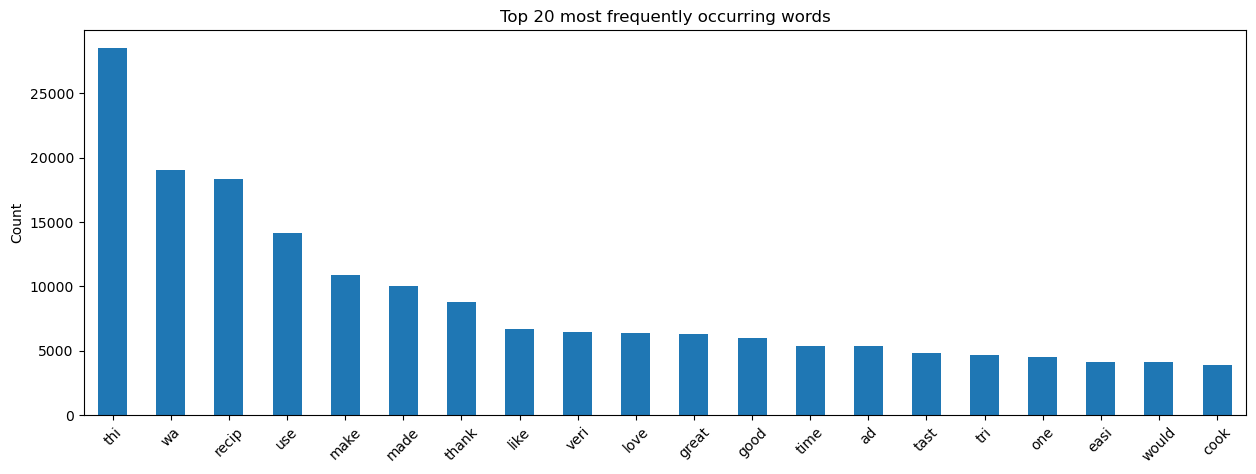

In [122]:
word_counts = pd.DataFrame(
    {"counts": X_train_sample_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Above we can visualize the most frequent ocurring words. This looks nice but its still not very useful, Since I want to know which words have the most impact on the comments/reviews, to know what the users value and what annoys them.

To check this, I will use a Logistic Regression

In [123]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_sample_transformed, y_train_sample)

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.7878214285714286
Test score: 0.7605


In [124]:
logreg_score = logreg.score(X_test_sample_transformed, y_test_sample)
logreg_score

0.7605

I used the Logistic regression with the countvectorizer, trained it and tested it, and it has an accuracy of 76% . Which means my model is 76% of the time correct, which is very nice.

Now that I used a logistic regression, I can visualize with coefficients, which words are the most associated with positive reviews.

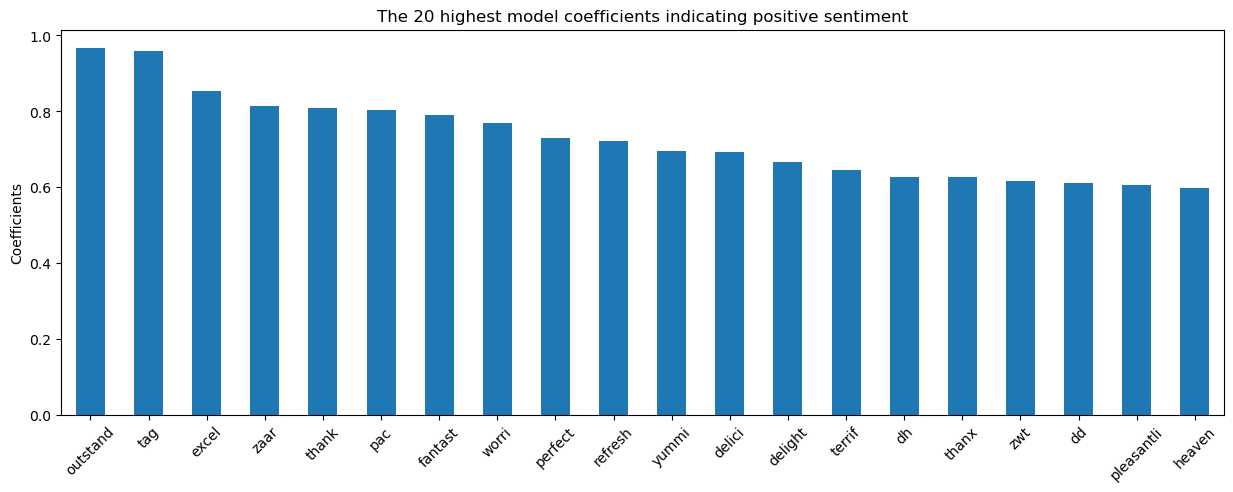

In [125]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

When visualiing the words above, it makes a lot of sence that words such as outstanding, excelent, fantastic and perfect are  associated with positive reviews. With some of the words such as  Delicious, ZWT (zero waiting time) and DH (diet history) we can see that users appreciate flavor, speed and nutritional value.

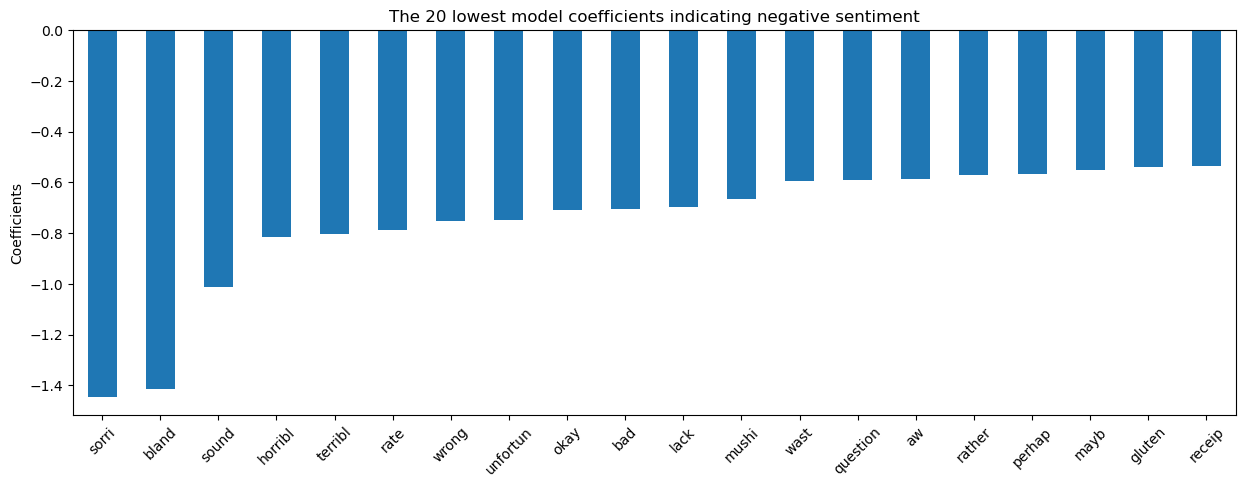

In [126]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

When checking on the negative words, we can check there are some like bland and gluten, which can tell us that customer perception and preferences, that they care about the texture and also that aparently many customers dont like recipes that have gluten.

In [127]:
print(bagofwords.vocabulary_)
print(bagofwords.get_feature_names())

{'forgot': 791, 'mention': 1237, 'oven': 1388, 'thi': 2032, 'hot': 981, 'use': 2143, 'combin': 407, 'ingredi': 1022, 'smoke': 1822, 'fill': 750, 'hous': 983, 'work': 2231, 'friend': 811, 'mine': 1256, 'made': 1185, 'seafood': 1729, 'gumbo': 918, 'okra': 1358, 'mani': 1197, 'differ': 578, 'meat': 1226, 'item': 1043, 'hope': 978, 'turn': 2114, 'correctli': 459, 'edibl': 647, 'first': 759, 'time': 2062, 'tri': 2101, 'recip': 1603, 'wa': 2171, 'thin': 2037, 'never': 1315, 'befor': 171, 'thought': 2046, 'suppos': 1958, 'like': 1142, 'put': 1565, 'top': 2083, 'fridg': 810, 'rise': 1658, 'cold': 400, 'clear': 383, 'could': 463, 'see': 1737, 'happen': 933, 'insid': 1024, 'surpris': 1962, 'kept': 1070, 'separ': 1748, 'sometim': 1847, 'inch': 1009, 'water': 2185, 'would': 2238, 'sit': 1796, 'stir': 1916, 'back': 126, 'togeth': 2073, 'onli': 1367, 'hour': 982, 'later': 1110, 'dump': 624, 'quot': 1579, 'version': 2163, 'talk': 1982, 'night': 1320, 'day': 532, 'actual': 13, 'creat': 483, 'expect': 

Above I am just checkign how many times each word is mentioned.

In [128]:
sample_reviews[sample_reviews['Review'].str.contains('zaar')]

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
1118827,252161,107135,Dienia B.,5,fast easy cheap tasty served with sarah beths peas recipe #428882 complete fast cheap meal zaar tour 6,2010-06-19T14:18:11Z,2010-06-19T14:18:11Z,1
1267367,139769,2042874,risingsun9365,0,"I just finished this recipe and shamelessly scraped and licked the spoons. It is amazing. I added 6 oz of chocolate instead of the 3 it calls for. I think that it has a great balance between sweet and chocolate. I am attending a crafters holiday bazaar this weekend, I'm hoping this will make a nice addition to my collection of jams and jellies that I sell. THANK YOU",2011-11-21T18:18:42Z,2011-11-21T18:18:42Z,0
873928,181206,137428,ctrmom,0,"I am assigning no stars because I have not yet made this as written, but this is as close as recipezaar has to the recipe our friends Newell and Karen gave us for Salsa Cruda de Tomatillo, which is 5 star excellent. The only real difference is jalapeno peppers instead of poblanos. Our recipe says 1 lb. tomatillos, 1 onion, 1 clove garlic, 2 jalapenos, 1 small bunch cilantro. I think we used 3/4 t salt. Thanks for posting!",2009-05-22T14:04:15Z,2009-05-22T14:04:15Z,0
899197,35813,992009,divertingbailey,5,Such amazing cookies! Even people who aren't huge fans of oatmeal cookies love these! Best cookie recipe I've gotten off 'zaar yet!,2009-07-02T12:30:11Z,2009-07-02T12:30:11Z,1
42088,50080,26584,Vic17460,2,"\r\nAs I looked this recipe over, I wondered how this would cook slowly for 30 minutes without liquid. Recipezaar Support was helpful, and encouraged me to find an answer and give it a try. I chose vegetable broth at ½ cup per serving. (2½ cups for 6 servings.) This seemed to be about right. I put the broth in after adding the cardamom and nutmeg in step 3. (The recipe calls for garlic twice &#8211; I chose to add it in step 1, and sautéed it with the onion.) Back to step 3, it is hard to brown that much chopped vegetable. The cabbage seems to release liquid, so the process is not real dry. I never got even the potatoes to brown, thought I stirred for over 10 minutes. I choose serranos for the peppers. I served it with injera bread. It is ok, but even with six chopped serranos, it comes across as kind of bland. This could be just because I am missing something about Ethiopian cooking. (More cardamom??) We have some Ethiopian restaurants in the area, and I shall give one a try before going on in an Ethiopian direction. \r\n",2003-02-20T07:19:16Z,2003-02-20T07:19:16Z,0
...,...,...,...,...,...,...,...,...
954408,387934,137302,CarrolJ,5,Wonderful served with salsa! I couldn't believe how much it resembles Chili Rellano in flavor. Surprisingly no one would ever know that there are torn pieces of flour tortillas even in this.I would think if you had any leftover it would be good inserted into a fresh tortilla with salsa and served as a breakfast burrito as well. Very good! Made for PAC Fall 2009.\n\nhttp://www.recipezaar.com/bb/viewtopic.zsp?t=310505&postdays=0&postorder=asc&start=0,2009-09-24T13:39:06Z,2009-09-24T13:39:06Z,1
833509,349579,58104,Rita1652,0,YUMMO! Comfort food this is!\r\nThere is a lot of juice that is released from the cabbage. It would be good to remove the top for half the cooking time. The Worcestershire sauce I added to the meat using only 1 teaspoon. Skipped the salt. used olive oil for sauteing the onions.\r\nMade for PAC http://www.recipezaar.com/bb/viewtopic.zsp?t=296583&postdays=0&postorder=asc&start=0\r\nThanks!,2009-03-23T18:36:34Z,2009-03-23T18:36:34Z,0
480449,84347,487387,Tee Angel,5,It was my turn to bake for the birthday girl at work. She requested 'anything cherry'. I searched through Recipezaar for something quick. This recipe was a huge hit at work! Thank you for posting.,2007-09-16T15:48:30Z,2007-09-16T15:48:30Z,1


In [129]:
pd.set_option('display.max_colwidth', None)

In [130]:
sample_reviews[sample_reviews['Review'].str.contains('zaar')]

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
1118827,252161,107135,Dienia B.,5,fast easy cheap tasty served with sarah beths peas recipe #428882 complete fast cheap meal zaar tour 6,2010-06-19T14:18:11Z,2010-06-19T14:18:11Z,1
1267367,139769,2042874,risingsun9365,0,"I just finished this recipe and shamelessly scraped and licked the spoons. It is amazing. I added 6 oz of chocolate instead of the 3 it calls for. I think that it has a great balance between sweet and chocolate. I am attending a crafters holiday bazaar this weekend, I'm hoping this will make a nice addition to my collection of jams and jellies that I sell. THANK YOU",2011-11-21T18:18:42Z,2011-11-21T18:18:42Z,0
873928,181206,137428,ctrmom,0,"I am assigning no stars because I have not yet made this as written, but this is as close as recipezaar has to the recipe our friends Newell and Karen gave us for Salsa Cruda de Tomatillo, which is 5 star excellent. The only real difference is jalapeno peppers instead of poblanos. Our recipe says 1 lb. tomatillos, 1 onion, 1 clove garlic, 2 jalapenos, 1 small bunch cilantro. I think we used 3/4 t salt. Thanks for posting!",2009-05-22T14:04:15Z,2009-05-22T14:04:15Z,0
899197,35813,992009,divertingbailey,5,Such amazing cookies! Even people who aren't huge fans of oatmeal cookies love these! Best cookie recipe I've gotten off 'zaar yet!,2009-07-02T12:30:11Z,2009-07-02T12:30:11Z,1
42088,50080,26584,Vic17460,2,"\r\nAs I looked this recipe over, I wondered how this would cook slowly for 30 minutes without liquid. Recipezaar Support was helpful, and encouraged me to find an answer and give it a try. I chose vegetable broth at ½ cup per serving. (2½ cups for 6 servings.) This seemed to be about right. I put the broth in after adding the cardamom and nutmeg in step 3. (The recipe calls for garlic twice &#8211; I chose to add it in step 1, and sautéed it with the onion.) Back to step 3, it is hard to brown that much chopped vegetable. The cabbage seems to release liquid, so the process is not real dry. I never got even the potatoes to brown, thought I stirred for over 10 minutes. I choose serranos for the peppers. I served it with injera bread. It is ok, but even with six chopped serranos, it comes across as kind of bland. This could be just because I am missing something about Ethiopian cooking. (More cardamom??) We have some Ethiopian restaurants in the area, and I shall give one a try before going on in an Ethiopian direction. \r\n",2003-02-20T07:19:16Z,2003-02-20T07:19:16Z,0
...,...,...,...,...,...,...,...,...
954408,387934,137302,CarrolJ,5,Wonderful served with salsa! I couldn't believe how much it resembles Chili Rellano in flavor. Surprisingly no one would ever know that there are torn pieces of flour tortillas even in this.I would think if you had any leftover it would be good inserted into a fresh tortilla with salsa and served as a breakfast burrito as well. Very good! Made for PAC Fall 2009.\n\nhttp://www.recipezaar.com/bb/viewtopic.zsp?t=310505&postdays=0&postorder=asc&start=0,2009-09-24T13:39:06Z,2009-09-24T13:39:06Z,1
833509,349579,58104,Rita1652,0,YUMMO! Comfort food this is!\r\nThere is a lot of juice that is released from the cabbage. It would be good to remove the top for half the cooking time. The Worcestershire sauce I added to the meat using only 1 teaspoon. Skipped the salt. used olive oil for sauteing the onions.\r\nMade for PAC http://www.recipezaar.com/bb/viewtopic.zsp?t=296583&postdays=0&postorder=asc&start=0\r\nThanks!,2009-03-23T18:36:34Z,2009-03-23T18:36:34Z,0
480449,84347,487387,Tee Angel,5,It was my turn to bake for the birthday girl at work. She requested 'anything cherry'. I searched through Recipezaar for something quick. This recipe was a huge hit at work! Thank you for posting.,2007-09-16T15:48:30Z,2007-09-16T15:48:30Z,1


I was very curious about certain words such as zaar, dh, zwt, pac, so I made the code above to start diging more into what they mean. I found out the following:
- Zaar: It was the previous name of the website was recipezaar.com and people often reffer to the site as Zaar, many of the comments say they are happy to find a recipe they found before in zaar, others jsut talking about the site (mostly the old comments).
- dh: abbreviation for Dietary history
- zwt: seemed like a random word but it actually is an abbreviation for Zero Waiting Time, makes sense to have it on positive since it means the recipe is very fast to make which makes people have a positive sentiment towards the recipe.
- pac: pace. Some people refer to the apce being fast and easy which is also positive.
- tag: was the most tricky one, the main one is people talking about being tagged on the recipe by someone or in most cases say they are 'tagging it' or 'tagged it' because they liked it (apparently they are saving it on favorites, maybe was a previous name from previous site since  most of this comments are old).  In some case no real meaning, 'tag game' was mentioned 169 times as well as people asking or talking about being tagged in certain recipe. 

# Testing sentences with CountVectorizer & Logreg

On this part I will just try to test my model and see if it can predict sentences correctly

In [131]:
# Preprocess the new sentence
new_sentence = "wonderful I love it, its amazing"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training

print(preprocessed_sentence)

#check recall , balance, confusion matrix, TIDF ---> different type (score based on how often they appear)
# check decision tree, knn, compre different models


['wonder', 'love', 'amaz']


In [132]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])
print([preprocessed_sentence])
print(logreg.predict(new_sentence_transformed))




[['wonder', 'love', 'amaz']]
[0]


Right away I found a problem. If I write a short positive comment, it doesnt detect it right aways as possitive. This is due that the coefficients on the CountVectorize, eventhough theya re positive, they are kind of low. So It needs (in most cases) more than 3 positive words to actually count it as positive.

In [133]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
# Preprocess the new sentence
new_sentence = "delicious, its very yummy, i love it"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
print(preprocessed_sentence)

new_sentence_transformed = bagofwords.transform([new_sentence])

print(logreg.predict(new_sentence_transformed))


['delici', 'veri', 'yummi', 'love']
[1]


Testing with more than 3 positive words, the log reg predicts that it is positive (1)

In [134]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
# Preprocess the new sentence
new_sentence = "good nice"
new_sentence = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string

print(preprocessed_sentence)

new_sentence_transformed = bagofwords.transform([preprocessed_sentence])
sentiment_prediction = logreg.predict(new_sentence_transformed)

if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")


good nice
The sentence has a negative sentiment.


Doing a second test, this time with printing if the sentiment is negative or positive instead of 1 or 0. In this one I only used 2 positive words, but it predicts it as negative sentiment, which is a problem

In [135]:
# Get predicted probabilities for positive class
y_pred_prob = logreg.predict_proba(X_test_sample_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.6  # threshold (experimenting with different values)
y_pred = (y_pred_prob >= threshold).astype(int)

# Calculate precision, recall, and other metrics
from sklearn.metrics import classification_report
print(classification_report(y_test_sample, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.82      0.76      4990
           1       0.79      0.65      0.71      5010

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



Above I did a report using Classification_report to chech the precision, recall, and oeveral score. My model seems to have problem predicting the positive ones, I will test tuning and other models to see if I can increase this.

One of the first things to predict better, is changing the threshold. For this I did the code below to domy program calculate the best threshold to have an accurate prediction. It found out that with a threshold of 0.4, the prediction is a lot more accurate.

In [136]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Obtain the predicted probabilities for the positive class
y_pred_prob = logreg.predict_proba(X_test_sample_transformed)[:, 1]

# Define the range of threshold values to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Initialize variables to store the best threshold and corresponding metric value
best_threshold = None
best_metric = 0.0

# Iterate over the threshold values
for threshold in thresholds:
    # Convert predicted probabilities into binary predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate the evaluation metric of interest (e.g., accuracy, precision, recall, F1 score)
    metric_value = accuracy_score(y_test_sample, y_pred)  # Replace with the desired metric
    
    # Check if the current metric value is better than the previous best
    if metric_value > best_metric:
        best_metric = metric_value
        best_threshold = threshold

# Print the best threshold and corresponding metric value
print("Best Threshold:", best_threshold)
print("Best Metric Value:", best_metric)


Best Threshold: 0.4
Best Metric Value: 0.7629


Now with this new parameter, I test again my model with only 2 positive words.

In [137]:
# Preprocess the new sentence
new_sentence = "amazing good"
preprocessed_sentence = my_tokenizer(new_sentence)
preprocessed_sentence = ' '.join(preprocessed_sentence)  # Join the tokens into a single string

# Transform the preprocessed sentence using the trained CountVectorizer
new_sentence_transformed = bagofwords.transform([preprocessed_sentence])

# Get the predicted probabilities for the positive class
y_pred_prob = logreg.predict_proba(new_sentence_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.4  # Set the desired threshold 
sentiment_prediction = int(y_pred_prob >= threshold)

# Print the sentiment prediction
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")


The sentence has a positive sentiment.


And it works! With a ower threshold, the  prediction is less demanding on the number of positive words it is rquired to do a prediction, which helps a lot amking an accurate one!

Below I will try checking which hyper parameters can benefit my model.

### Tuning Hyper parameters

WIth the code below I will try checking which C value would be the best for my Logistic Regession.

In [138]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_sample_transformed, y_train_sample)

# Print the best parameter and the corresponding score
print("Best parameter:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Training and test score of the best model
print(f"Train score: {best_model.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {best_model.score(X_test_sample_transformed, y_test_sample)}")


Best parameter: {'C': 0.1}
Best score: 0.7571428571428571
Train score: 0.7878214285714286
Test score: 0.7605


In [139]:
# my logreg is already with C = 0.1

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.7878214285714286
Test score: 0.7605


My log reg was already with c:0.1, so luckily i was already using the model with the best parameter available.

Next I will try a different way of doing everything i did in this section.

# Section4
## TF-IDFVectorizer

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF Vectorizer helps in capturing the relative importance of words in a document or a corpus. It decreases the weight of common words like "the," "is," etc., that appear frequently across all documents.
It can help in reducing the impact of noise words that occur frequently but do not carry much semantic meaning. And it increases the weight of words that dont appear as often.
So I want to see if this model perform better in my sentiment analysis than the CountVetorizer.

In [141]:
tfidf = TfidfVectorizer(min_df=20,
                        tokenizer=my_tokenizer)
tfidf.fit(X_train_sample)

X_train_transformed = tfidf.transform(X_train_sample)
X_test_transformed = tfidf.transform(X_test_sample)

X_train_transformed.shape

(28000, 2277)

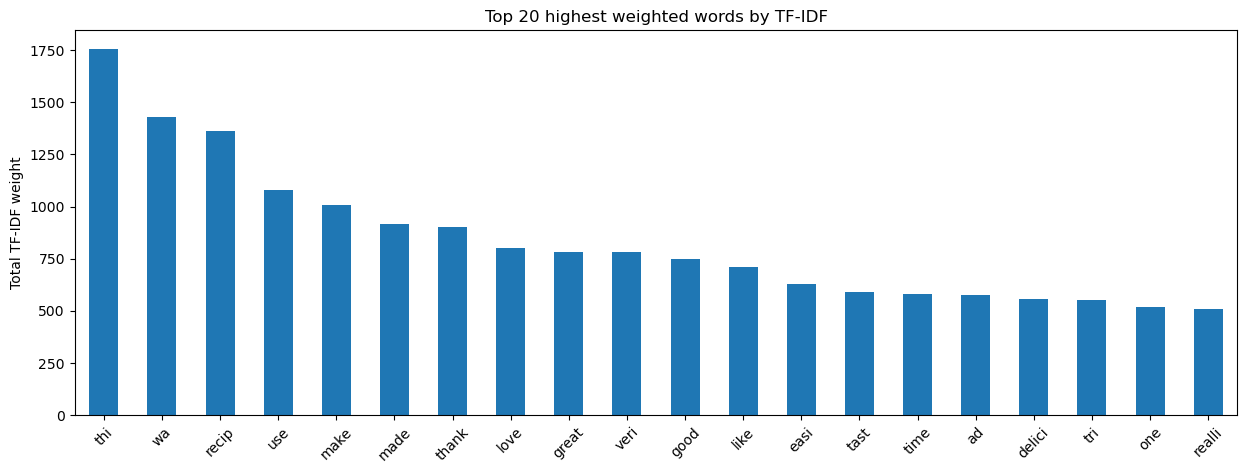

In [142]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

The top ocurring words are the same as in the last model, so until now there hasnt been much change.

Next, I will do a logitic regression with it and see if the change of weight actually impacts the model and the results

In [143]:
mylogreg = LogisticRegression()
mylogreg.fit(X_train_transformed, y_train_sample)

LogisticRegression()

In [144]:
coefficients = mylogreg.coef_[0]
word_coefficients = pd.DataFrame({"word": tfidf.get_feature_names(), "coefficient": coefficients})
top_positive_words = word_coefficients.sort_values("coefficient", ascending=False).head(20)


I will check the words in a DataFrame way and in a graph

In [145]:
top_positive_words

,word,coefficient
2023,thank,5.273376
1979,tag,4.129741
897,great,3.696792
1447,perfect,3.504450
1387,outstand,3.386321
2227,wonder,3.276018
571,dh,3.136232
693,excel,3.105115
1398,pac,3.087588
720,fantast,3.054140


And now, I will check again the positive words but with the new vectorizer

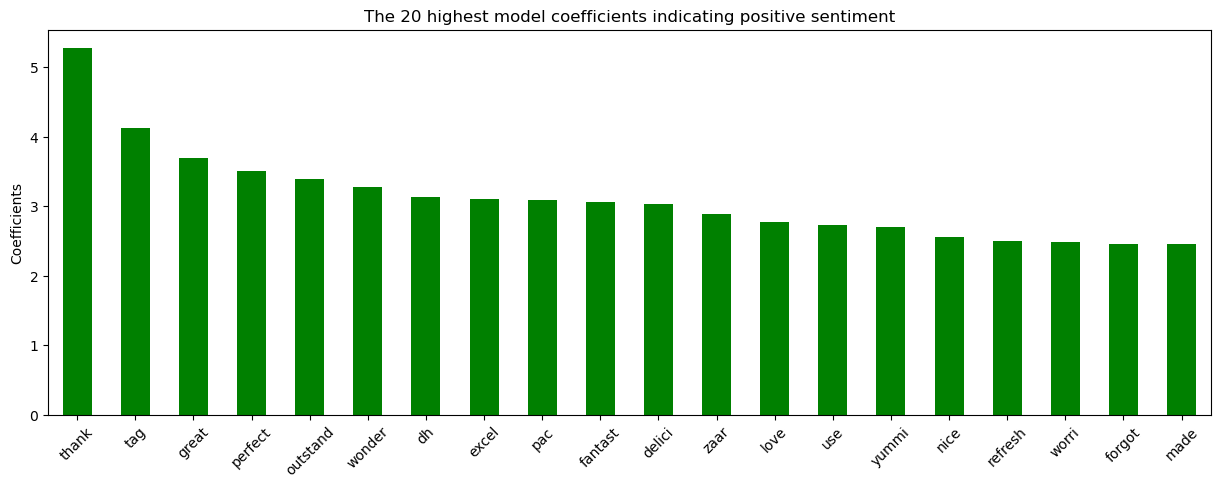

In [146]:
word_counts = pd.DataFrame(
    {"coefficients": mylogreg.coef_[0]},
    index=tfidf.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color = 'green')
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

With TfidfVectorizer, the coefficients are a lot better! this would help me a lot on my sentiment analysis! The words are mostly the same, but the CountVectorizer had coefficients between 0 and 1 for the positive ones, which required me to reduce the threshold and do other stuff to be abe to predict short reviews. This model seems a lot better on termns of coefficient, since the weight of positive words is a lot better.

Next, I will check the negative words

In [147]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [148]:
word_counts = pd.DataFrame(
    {"coefficients": mylogreg.coef_[0]},
    index=tfidf.get_feature_names()
).sort_values("coefficients", ascending=False)


In [149]:
word_dict = word_counts.to_dict()['coefficients']


In [150]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)


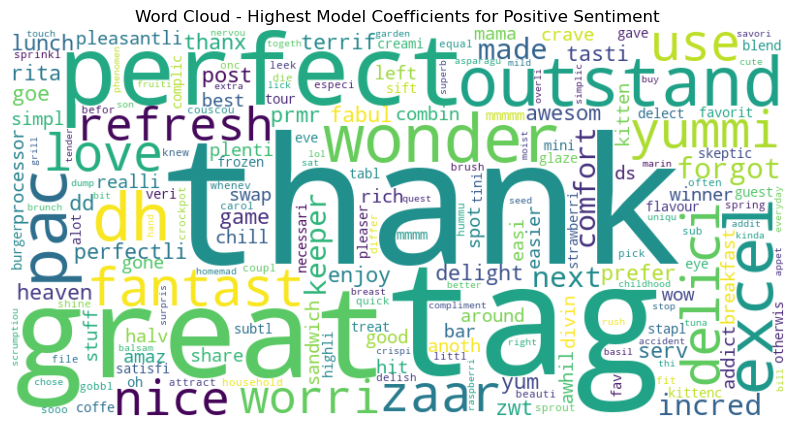

In [151]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Highest Model Coefficients for Positive Sentiment")
plt.show()


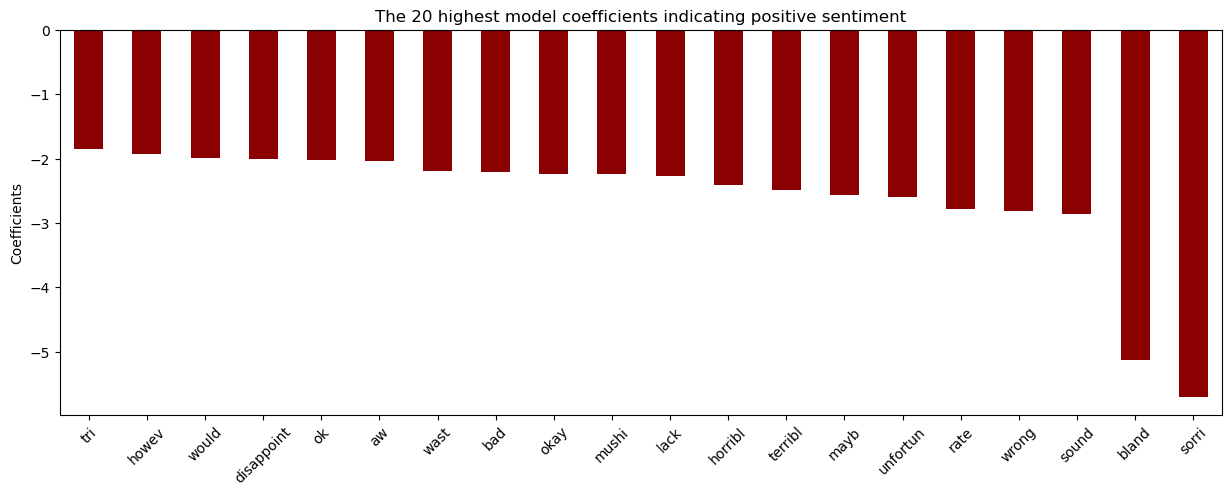

In [61]:
word_counts = pd.DataFrame(
    {"coefficients": mylogreg.coef_[0]},
    index=tfidf.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.tail(20).plot(kind="bar", figsize=(15, 5), legend=False, color = 'darkred')
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

The negtive words also have a ot better coefficient thatn my original CountVectorizer!  This would also mean that the comment will need less negative words to make a correct prediction (when dealing with short reviews)

In [62]:
print(f"Train score: {mylogreg.score(X_train_transformed, y_train_sample)}")
print(f"Test score: {mylogreg.score(X_test_transformed, y_test_sample)}")

Train score: 0.7908928571428572
Test score: 0.7655


In [63]:
mylogreg_score = mylogreg.score(X_test_transformed, y_test_sample)
mylogreg_score

0.7655

In [157]:
import joblib


In [158]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(mylogreg, 'mylogreg_model.pkl')

['mylogreg_model.pkl']

The score is basicaly the same  as the previous logistic regression with CountVectorizer (but the accuracy of this one is ~0.5 higher), while having higher coefficients which will have more weight when analyzing sentences!

And now the test with sentences to see how better it does!

In [64]:
# Preprocess the new sentence
new_sentence = "waste"
preprocessed_sentence = my_tokenizer(new_sentence)
preprocessed_sentence = ' '.join(preprocessed_sentence)  # Join the tokens into a single string

# Transform the preprocessed sentence using the trained vectorizer
new_sentence_transformed = bagofwords.transform([preprocessed_sentence])

# Get the predicted probabilities for the positive class
y_pred_prob = mylogreg.predict_proba(new_sentence_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.4  # Set the desired threshold 
sentiment_prediction = int(y_pred_prob_prob >= threshold)

print([preprocessed_sentence])


# Print the sentiment prediction
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")


['wast']
The sentence has a negative sentiment.


In [65]:
# Preprocess the new sentence
new_sentence = "nice"
preprocessed_sentence = my_tokenizer(new_sentence)
preprocessed_sentence = ' '.join(preprocessed_sentence)  

# Transform the preprocessed sentence using the trained Vectorizer
new_sentence_transformed = bagofwords.transform([preprocessed_sentence])

# Get the predicted probabilities for the positive class
y_pred_prob = mylogreg.predict_proba(new_sentence_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.4  
sentiment_prediction = int(y_pred_prob >= threshold)

print([preprocessed_sentence])


# Print the sentiment prediction
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")

['nice']
The sentence has a positive sentiment.


In [66]:
# Preprocess the new sentence
new_sentence = "Wow this recipe is very good, I love it"
preprocessed_sentence = my_tokenizer(new_sentence)
preprocessed_sentence = ' '.join(preprocessed_sentence)  

# Transform the preprocessed sentence using the trained CountVectorizer
new_sentence_transformed = bagofwords.transform([preprocessed_sentence])

# Get the predicted probabilities for the positive class
y_pred_prob = mylogreg.predict_proba(new_sentence_transformed)[:, 1]

# Adjust the decision threshold
threshold = 0.4  
sentiment_prediction = int(y_pred_prob >= threshold)

print([preprocessed_sentence])


# Print the sentiment prediction
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")

['wow thi recip veri good love']
The sentence has a positive sentiment.


And it is working even with one word now! Because coefficients are higher, they hav e ahigher weight, so now my sentence doesnt need more than 3 keywords as before to be able to effectively predict the sentiment of the sentence! This model has the same positive aspects of the previous one while adding that it correctly predicts short reviews (even of 1 word).

# Section5
## testing other models

Eventhought my goal was reached (getting the positive and negative sentiment words), I will test other models to see the difference on accuracy between models to see how they perform in this scenario

## KNN

The first model that I will try is KNN

In [67]:
tfidf = TfidfVectorizer(tokenizer = my_tokenizer).fit(sample_reviews["Review"])
sample_transformed = tfidf.transform(sample_reviews["Review"])

tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=sample_transformed.toarray())
display(tfidf_df)

,aa,aaaaaaaaaaaaaaahss,aaaaaaag,aaaaaahhh,aaaaaamaz,aaaah,aaaahaaaa,aaaahh,aaaahhh,aaaargggh,...,zwtii,zwtiii,zwtour,zydeco,zzzing,zzzzz,zürichgschetzelt,zürigschnetzelt,ã,ãœ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
preprocessed_text_data = []

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

for text in sample_reviews['Review']:
    # Tokenize the text
    tokens = my_tokenizer(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Perform stemming
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the tokens into a single string
    preprocessed_text = ' '.join(tokens)
    
    # Add the preprocessed text to the list
    preprocessed_text_data.append(preprocessed_text)
preprocessed_text_data

['thi fabul easi recip top bottom top loav replac appl pear tree work fine wonder aroma hou thi bake',
 'tri mani mani mexican rice recip thi best far great textur balanc flavor use tomato use tomato past',
 'realli good smell great cook could wait tear',
 'veri tasti handl thing spici flavor thi sauc realli delici bother much great color sure long thi keep though',
 'thi perfect lasagna experi make scratch asham admit wa worri would go work make realli much wish lazi bought frozen glad tri thi becau never buy frozen lasagna thi tast superior much work fri ground turkey clove garlic minc season parsley basil salt pepper ad sauc otherwi follow instruct never made lasagna thi great recip start easi delici thank perfect lasagna recip mizznezz',
 'sure cupcak tradit sen remind lot old fashion quot cake quot grandmoth use make like popular cake cake made befor invent lubric pass quot edibl quot crisco alway made muffin ad flavor fruit want never ice cupcak oh tri use crisco rather butter',


On the code below I will run the whole KNN with the CountVecrotizer and test its accuracy on how well it it predicted the outcome

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



# Feature extraction
vectorizer = CountVectorizer()  # You can also use TfidfVectorizer
X = vectorizer.fit_transform(preprocessed_text_data)
y = sample_reviews['Sentiment']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Instantiate and train the KNN model
k = 5  
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)


#  Evaluate
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)






In [70]:
accuracy

0.6335333333333333

The accuracy of KNN is 0.6377. This is relatively lower than both logistic regressions. I will save it in a variable to be able to compare all the models used at the end.

In [71]:
knn_accuracy = accuracy.copy()
knn_accuracy

0.6335333333333333

In [72]:
X = vectorizer.fit_transform(preprocessed_text_data)
y = sample_reviews['Sentiment']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Range to be evaluated
k_values = range(2, 10)

# Store different k values
k_scores = {}

# Loop k values and train KNN models
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    k_scores[k] = accuracy

# Find the best k value with the highest accuracy
best_k = max(k_scores, key=k_scores.get)
best_accuracy = k_scores[best_k]

print("Best k:", best_k)
print("Accuracy:", best_accuracy)

Best k: 9
Accuracy: 0.6443333333333333


In [73]:
knn_accuracy = best_accuracy.copy()

With optimize K value, the accuracy goes up to 64.4%. The problem is that even with the best K value, Knn model has still a lower accuracy than the previous models. Next, I will try to see how Decision Tree model performs.

### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [75]:
X_train, X_test, y_train, y_test = train_test_split(sample_reviews['Review'], sample_reviews['Sentiment'], test_size=0.3, random_state=1)

In [76]:
# instantiate
dt = DecisionTreeClassifier()

vectorizer = CountVectorizer()
# train and transform
X_train_transform = vectorizer.fit_transform(X_train)
X_test_transform = vectorizer.transform(X_test)

#fit
dt.fit(X_train_transform, y_train)


DecisionTreeClassifier()

In [77]:
y_pred = dt.predict(X_test_transform)

In [78]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Decision Tree is:", accuracy)

Accuracy for Decision Tree is: 0.7002


In [79]:
dt_score = accuracy.copy()

In [80]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Perform grid search cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train_transform, y_train)

# Get the best estimator and its corresponding hyperparameters
best_dt = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict using the best estimator
y_pred = best_dt.predict(X_test_transform)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Decision Tree is:", accuracy)
print("Best hyperparameters:", best_params)

Accuracy for Decision Tree is: 0.7187333333333333
Best hyperparameters: {'max_depth': 15, 'min_samples_split': 2}


In [81]:
dt_score = accuracy.copy()

By tunning the hyperparameters, the decision tree goes up by 1%.

# Conclusion

Here is a table to show the accuracy of each model and below that, the conclusion my sentiment Analysis.

In [82]:

# creating a dictionary with the scores of my models
model_scores = {
    'Model': ['KNN', 'Decision Tree', 'LogReg (CountVectorizer)', 'LogReg (TF-IDF Vectorizer)' ],
    'Score': [knn_accuracy, dt_score, logreg_score, mylogreg_score]
}


score_table = pd.DataFrame(model_scores)

# Display the table

display(score_table)









,Model,Score
0,KNN,0.644333
1,Decision Tree,0.718733
2,LogReg (CountVectorizer),0.760500
3,LogReg (TF-IDF Vectorizer),0.765500


In [159]:
sample_reviews.to_csv('sample_reviews.csv', index=False)

### Models
When comparing Different models for the sentiment analysis it can be seen that all of them are relatively close on score. 

First, the KNN algorithm, even when optimized, was the lowest, with an accuracy of around 64%. Even when KNN is a simple and intuitive algorithm, the accuracy tells that it may not be the best choice for this specific project.

Then on the accuracy score, comes Decision Tree. The decision Tree with the tunned hyperparameters does better (in terms of accuracy) than the KNN. An advantage of the Decision Tree if used further, is that it is more resistant to noise and outliers (comparing it with other models), the 71% of accuracy that it got is not bad and could be a nice option.

Still, the two that shined today were both logistic regressions. The one done with CountVectorizer and the one done with TF-IDFVectorizer, with 76% and 76.5% respectively. The one that I personally liked better for the prediction was the LogReg (TF-IDF Vectorizer), since it has the highest accuracy, while also making it easier to make the finding visible and can be implemented easily for a prediction function.

Based on these results I can conclude that the Logistic Regression with TF-IDF Vectorizer outperformed the other models and should be used for further exploration and prediction.

### Key findings
I found the top keywords that people used for positive and sentiment analysis. In the first LogReg, the words didn’t have enough weight for the sentiment prediction in short sentences, but it was very effective in longer sentences with more keywords. Thanks to the TF-IDF Vectorizer and the Logistic Regression, my sentiment prediction function works a lot better even for short reviews of 1 or 2 words. 

With the keywords, it can be seen what customers value(positive words), and what they hate (negative words), also having the prediction function is correctly predicting the reviews that I input,  which could be very useful for companies that have millions of reviews and they want to have a general view of what people are saying about them, and manually doing this every time can be very time consuming and costly.
